In [1]:
import pandas as pd
import numpy as np
import acessos as ac
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
query = '''

select * from customer_sandbox_zone.segmentacao_digital_credito_flavia
order by rand()
limit 50000

'''

In [3]:
df = ac.df_athena('flavia-costa', query)

In [63]:
df.columns

Index(['cpf', 'tempo_relacionamento', 'ds_risk_type', 'gender',
       'nr_declared_income', 'ds_region', 'ds_occupation', 'nm_current_os',
       'ds_city_size', 'flag_autonomo', 'nr_trans_pix',
       'nr_antecipacao_fatura', 'flag_bolso', 'nr_purchases_virtual',
       'avg_vl_total_spending', 'nr_purchases_online',
       'nr_purchases_contactless', 'nr_recarga_credito', 'nr_acessos',
       'pc_acessos_lojawill', 'nr_pagamentos_conta',
       'nr_pagamentos_conta_credito', 'trans_recorrente',
       'trans_mobilidade_app', 'trans_delivery', 'trans_recarga_geral',
       'trans_streaming', 'trans_rede_social', 'trans_games', 'trans_cripto',
       'ds_cluster_sociodemographic', 'ordem', 'cluster', 'gr_virtual',
       'gr_online', 'gr_contactless', 'gr_mobilidade', 'gr_pix',
       'cluster_regra'],
      dtype='object')

In [4]:
for column in df.columns:
  if df[column].dtype == 'object' or df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object' and df[column].dtype != 'string':
    df[column].fillna(df[column].median(), inplace = True)

In [5]:
features_cluster = ['nr_trans_pix',
       'nr_antecipacao_fatura', 'flag_bolso', 'nr_purchases_virtual',
       'avg_vl_total_spending', 'nr_purchases_online',
       'nr_purchases_contactless', 'nr_recarga_credito', 'nr_acessos',
       'pc_acessos_lojawill', 'nr_pagamentos_conta',
       'nr_pagamentos_conta_credito', 'trans_recorrente',
       'trans_mobilidade_app', 'trans_delivery', 'trans_recarga_geral',
       'trans_streaming', 'trans_rede_social', 'trans_games', 'trans_cripto']

base_cluster = df[features_cluster]

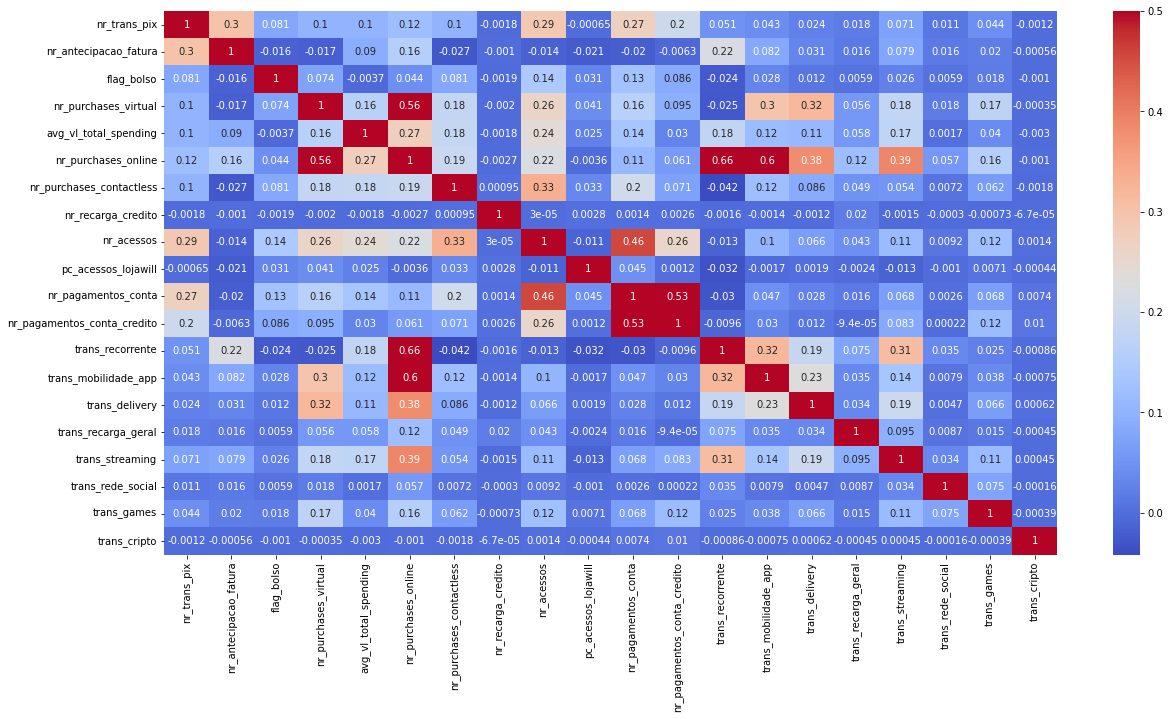

In [49]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df[features_cluster].corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [29]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans

In [30]:
#NORMALIZAÇÃO
scaler = RobustScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)

/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


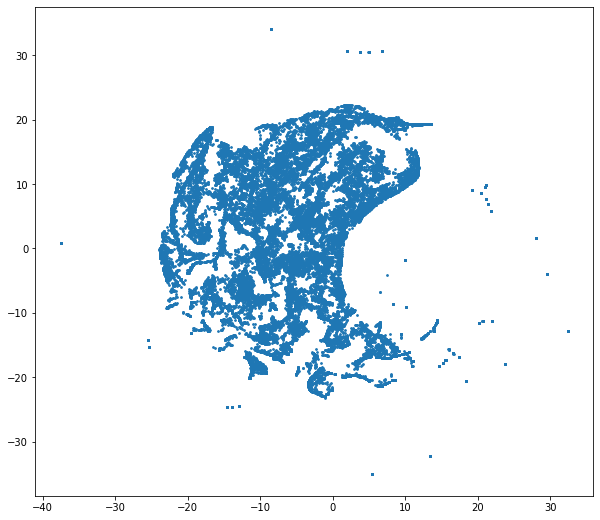

In [31]:
tsne = TSNE(n_components=2, random_state=0)
base_cluster_tsne = tsne.fit_transform(data_input_scaled)

plt.figure(figsize=(10,9))
plt.scatter(base_cluster_tsne[:, 0], base_cluster_tsne[:, 1], s=3, cmap='Spectral')
plt.show()

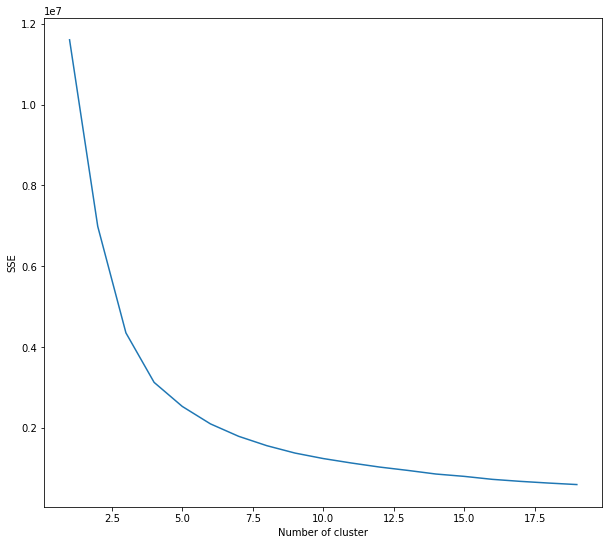

In [32]:
#AVALIANDO MELHOR NR DE CLUSTERS
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(base_cluster_tsne)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [34]:
#DEFININDO NR DE CLUSTERS
k = 15

#ALGORITMO
kmeans = KMeans(n_clusters = k, random_state=0).fit(base_cluster_tsne)


cluster = kmeans.predict(base_cluster_tsne)
base_cluster['cluster'] = cluster
df['cluster'] = cluster


print("---------------VOLUMETRIA ------------------")
print(df['cluster'].value_counts())


---------------VOLUMETRIA ------------------
0     13700
7      3884
9      3723
12     3549
1      3340
5      3317
6      3117
10     2861
2      2833
8      2605
13     2543
3      2428
4      1129
11      595
14      376
Name: cluster, dtype: int64


/tmp/ipykernel_279442/1900069649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster['cluster'] = cluster


In [35]:
print("---------------VOLUMETRIA ------------------")
print(df['cluster'].value_counts(normalize = True))

---------------VOLUMETRIA ------------------
0     0.27400
7     0.07768
9     0.07446
12    0.07098
1     0.06680
5     0.06634
6     0.06234
10    0.05722
2     0.05666
8     0.05210
13    0.05086
3     0.04856
4     0.02258
11    0.01190
14    0.00752
Name: cluster, dtype: float64


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(base_cluster[features_cluster]
                                                    , base_cluster['cluster']
                                                    , random_state=42, test_size=0.20)
arvores = [50, 100, 300, 400]
accuracy_array = []

for i in arvores:
  rf = RandomForestClassifier(n_estimators=i)
  rf.fit(x_train, y_train)
  y_predicted_rf = rf.predict(x_test)
  accuracy_rf = accuracy_score(y_test, y_predicted_rf).round(4)
  accuracy_array.append(accuracy_rf)
  print(i)
rf_estimators = pd.DataFrame(list(zip(arvores, accuracy_array)), columns =['arvores', 'acuracia'])
print("---------------ACURACCY CLASSIFICATION ------------")
rf_estimators['acuracia'].max()



50
100
300
400
---------------ACURACCY CLASSIFICATION ------------


0.9535

---------------IMPORTANCIA DAS FEATURES - O QUE MAIS PESOU NA CONSTRUÇÃO DOS GRUPOS? ------------


<AxesSubplot:>

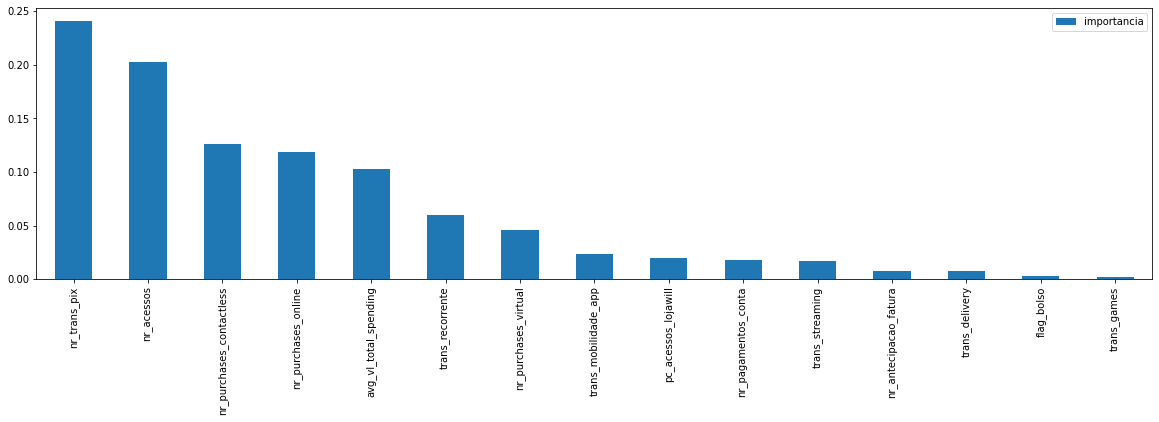

In [37]:
print("---------------IMPORTANCIA DAS FEATURES - O QUE MAIS PESOU NA CONSTRUÇÃO DOS GRUPOS? ------------")
best_rf = RandomForestClassifier(n_estimators= rf_estimators['arvores'][rf_estimators['acuracia'].idxmax()])
best_rf.fit(x_train, y_train)
importance_df = pd.DataFrame(best_rf.feature_importances_, columns = ['importancia'], index = features_cluster)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))


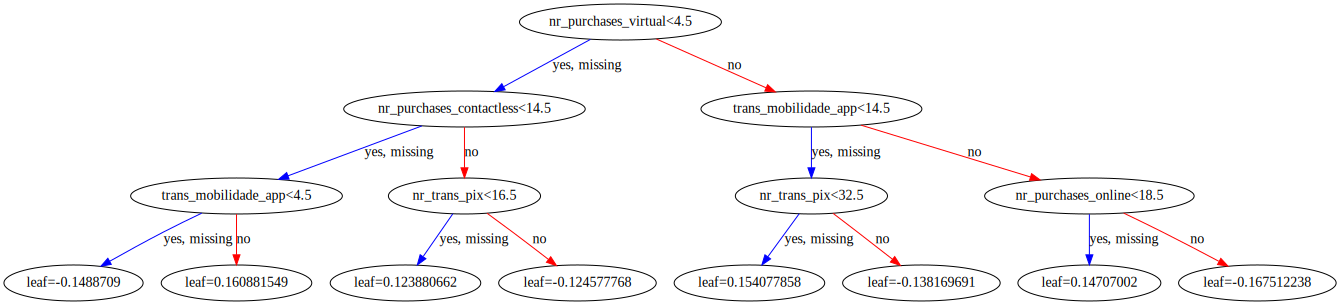

In [38]:
#utilizando o xgboost
import xgboost as xgb
clf = xgb.XGBClassifier(objective="multi:softprob", max_depth=3, random_state=42) #early_stopping_rounds=2
clf.fit(x_train, y_train)
#arvore de decisão
import graphviz
xgb.to_graphviz(clf, num_trees=clf.best_iteration)

In [105]:
df['gr_virtual'] = np.where(df.nr_purchases_virtual < 5, "A", "B")

df['gr_online'] = np.where(df.nr_purchases_online < 19, "A", "B")

df['gr_contactless'] = np.where(df.nr_purchases_contactless < 15, "A", "B")

df['gr_mobilidade'] = np.where(df.trans_mobilidade_app < 5, "A", 
                       np.where(df.trans_mobilidade_app < 15, "B", "C"))

df['gr_pix'] = np.where(df.nr_trans_pix < 17, "A", 
                       np.where(df.nr_trans_pix < 33, "B", "C"))

df['cluster_regra'] = df['gr_virtual'] + df['gr_online'] + df['gr_contactless'] + df['gr_mobilidade'] + df['gr_pix']

df['cluster_regra'].value_counts()

AAAAA    34116
AABAA     3178
AAAAC     1785
AAAAB     1507
BAAAA     1430
         ...  
BABCA        4
AABCC        3
AAACB        3
BABCC        2
BAACC        1
Name: cluster_regra, Length: 70, dtype: int64

In [39]:
features_importantes = importance_df.sort_values(by='importancia', ascending=False).head(20).index
features_importantes

Index(['nr_trans_pix', 'nr_acessos', 'nr_purchases_contactless',
       'nr_purchases_online', 'avg_vl_total_spending', 'trans_recorrente',
       'nr_purchases_virtual', 'trans_mobilidade_app', 'pc_acessos_lojawill',
       'nr_pagamentos_conta', 'trans_streaming', 'nr_antecipacao_fatura',
       'trans_delivery', 'flag_bolso', 'trans_games', 'trans_recarga_geral',
       'nr_pagamentos_conta_credito', 'trans_rede_social',
       'nr_recarga_credito', 'trans_cripto'],
      dtype='object')

In [40]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

print("---------------MEDIAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
df[totalfeat].groupby('cluster').mean().style.apply(highlight_max)


---------------MEDIAS POR CLUSTER ------------


,nr_trans_pix,nr_antecipacao_fatura,flag_bolso,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_purchases_contactless,nr_recarga_credito,nr_acessos,pc_acessos_lojawill,nr_pagamentos_conta,nr_pagamentos_conta_credito,trans_recorrente,trans_mobilidade_app,trans_delivery,trans_recarga_geral,trans_streaming,trans_rede_social,trans_games,trans_cripto
cluster,,,,,,,,,,,,,,,,,,,,
0,6.000438,0.000000,0.000000,0.000000,720.480534,3.000000,0.000000,0.000000,53.000438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8.723653,0.161377,0.037725,0.623653,1769.733352,4.100299,1.388623,0.000898,86.030838,0.010207,0.813473,0.024850,0.214072,0.102695,0.218563,0.064072,0.108982,0.005988,0.129940,0.000000
2,2.292270,0.000706,0.020826,0.278150,770.921749,1.525238,1.390046,0.000000,22.915284,0.019204,0.384398,0.008119,0.001765,0.085775,0.015884,0.010942,0.078715,0.001059,0.008825,0.000000
3,64.520181,0.415568,0.114498,17.859555,1610.926588,25.670511,20.542422,0.000000,187.525124,0.010743,2.850906,0.166804,1.267298,1.942751,1.981878,0.155272,2.521829,0.051483,0.430807,0.000000
4,5.997343,0.000000,0.024801,0.000000,598.986632,2.497786,0.004429,0.000000,7.031887,0.036107,0.000886,0.000000,0.000000,0.001771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2.198372,0.144106,0.025626,0.074163,817.188931,1.898402,0.423576,0.000301,60.221586,0.004963,0.233946,0.006934,0.079891,0.049744,0.059994,0.008441,0.038288,0.002713,0.012964,0.000603
6,26.946744,0.460058,0.083414,1.150465,964.663598,6.221046,5.763876,0.000000,103.354828,0.009379,1.363811,0.068977,0.810074,0.250561,0.223933,0.051652,0.829002,0.040103,0.080205,0.000000
7,4.287848,0.000257,0.021370,1.668126,924.877550,3.341143,8.128991,0.000515,49.367662,0.017801,0.559990,0.007467,0.000000,0.088054,0.128476,0.023687,0.177394,0.003347,0.042997,0.000257
8,4.520154,0.231094,0.003071,0.046449,1190.085014,7.937044,0.168906,0.000000,54.270633,0.000998,0.039539,0.000384,4.017274,0.360077,0.269866,0.099040,2.049136,0.011132,0.072553,0.000000


In [41]:
print("---------------MEDIANAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
df[totalfeat].groupby('cluster').median().style.apply(highlight_max)

---------------MEDIANAS POR CLUSTER ------------


,nr_trans_pix,nr_antecipacao_fatura,flag_bolso,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_purchases_contactless,nr_recarga_credito,nr_acessos,pc_acessos_lojawill,nr_pagamentos_conta,nr_pagamentos_conta_credito,trans_recorrente,trans_mobilidade_app,trans_delivery,trans_recarga_geral,trans_streaming,trans_rede_social,trans_games,trans_cripto
cluster,,,,,,,,,,,,,,,,,,,,
0,6.000000,0.000000,0.000000,0.000000,720.468333,3.000000,0.000000,0.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8.000000,0.000000,0.000000,0.000000,720.468333,2.000000,0.000000,0.000000,76.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.000000,0.000000,0.000000,0.000000,720.468333,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,60.000000,0.000000,0.000000,0.000000,941.870000,8.000000,3.000000,0.000000,124.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,6.000000,0.000000,0.000000,0.000000,720.468333,3.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2.000000,0.000000,0.000000,0.000000,720.468333,1.000000,0.000000,0.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,25.000000,0.000000,0.000000,0.000000,651.666667,3.000000,0.000000,0.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,5.000000,0.000000,0.000000,0.000000,620.835500,2.000000,8.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,6.000000,0.000000,0.000000,0.000000,804.718333,6.000000,0.000000,0.000000,53.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_trans_pix


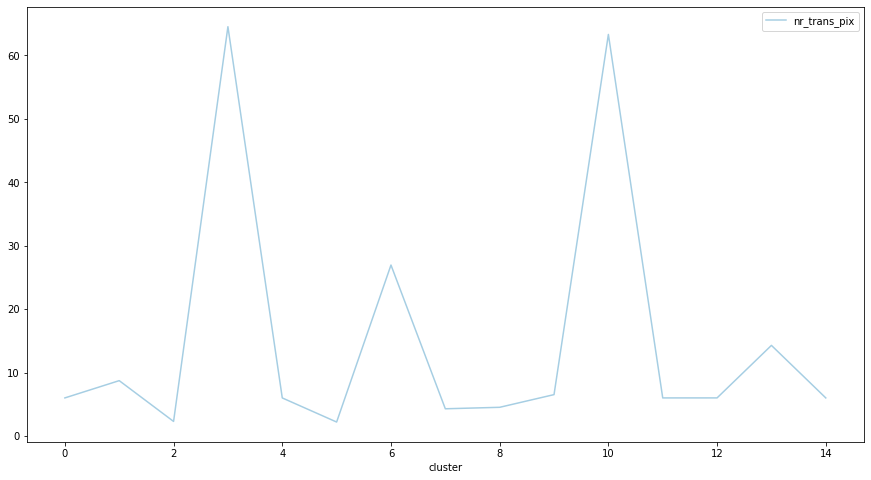

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_acessos


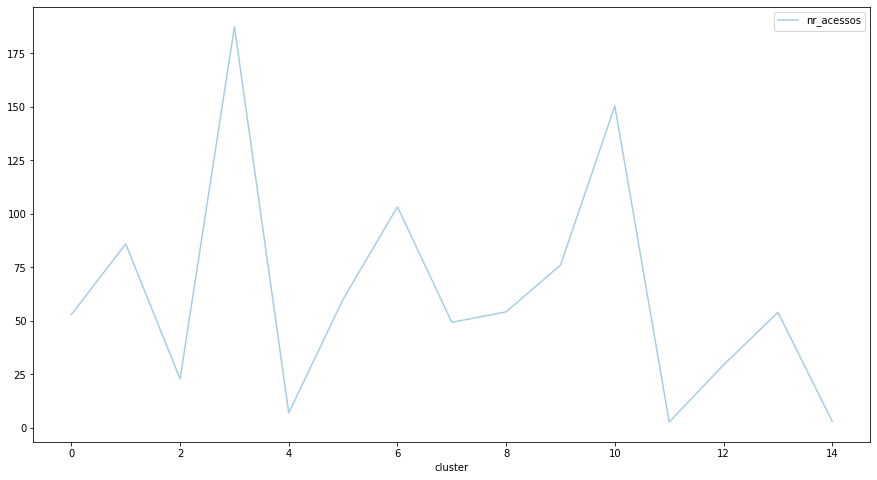

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_purchases_contactless


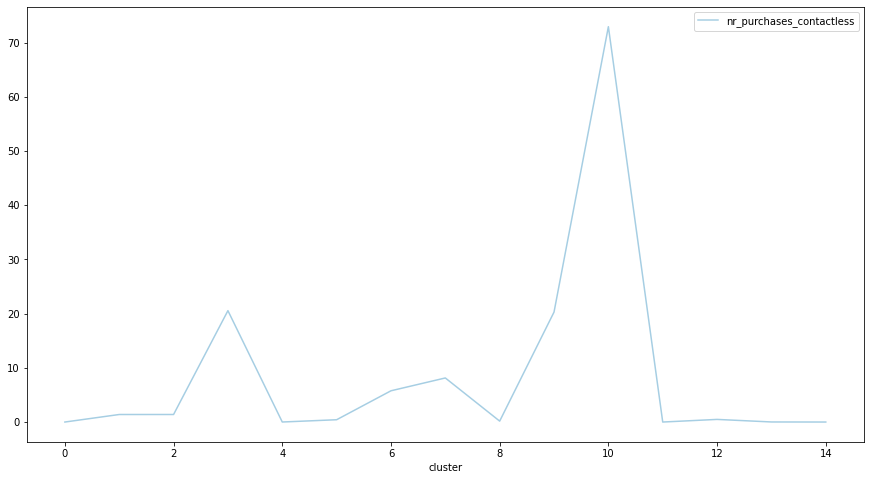

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_purchases_online


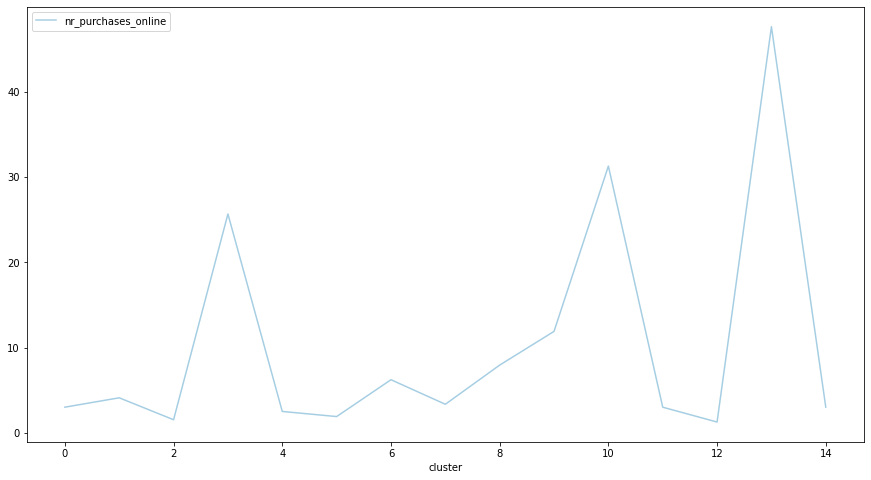

---------------MEDIAS POR CLUSTER GRÁFICO ------------
avg_vl_total_spending


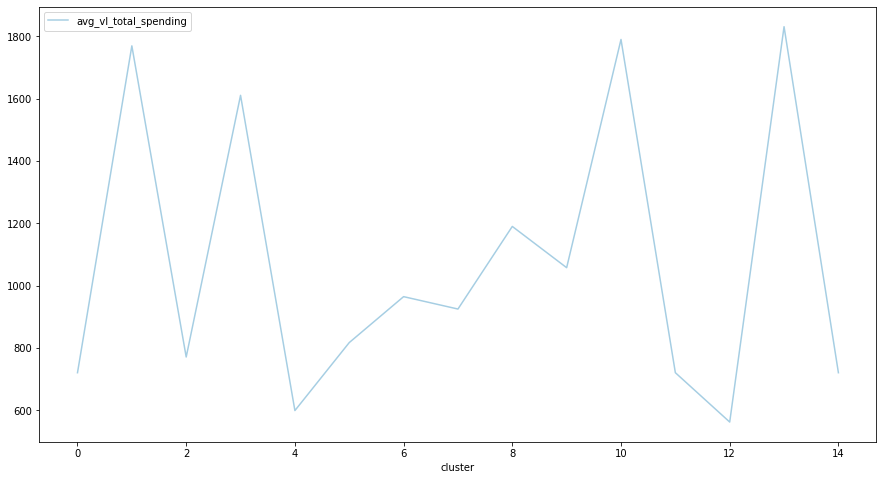

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_recorrente


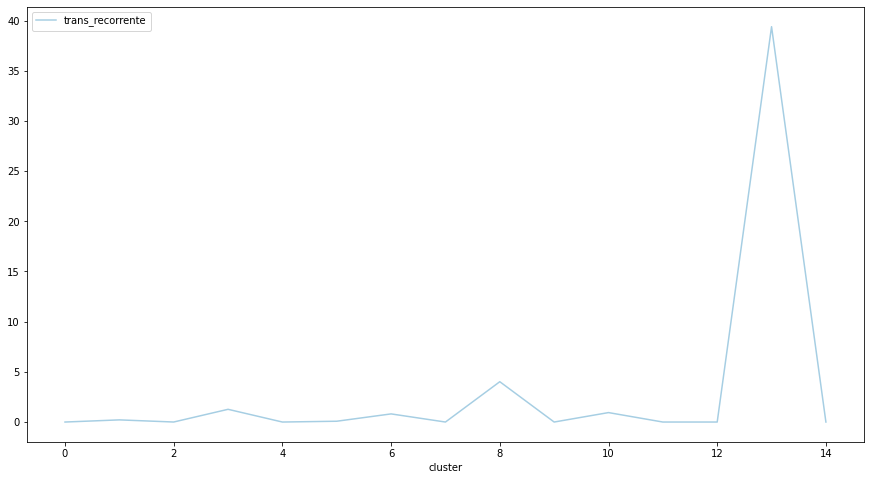

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_purchases_virtual


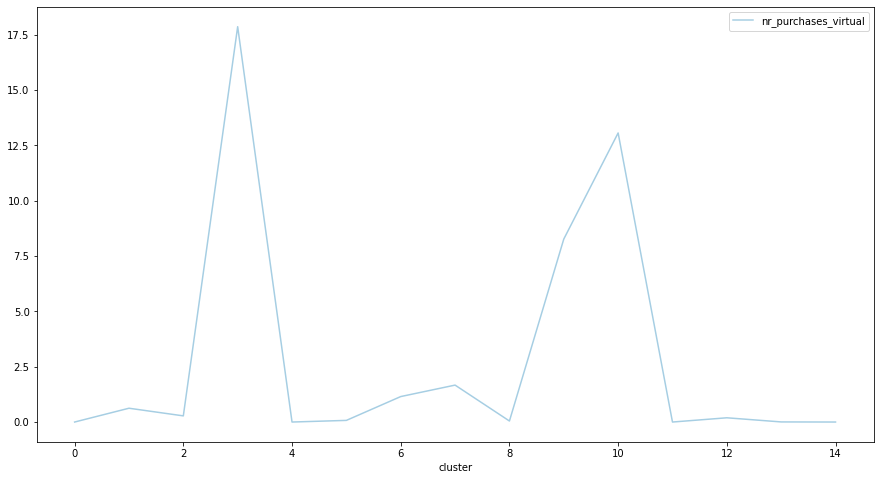

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_mobilidade_app


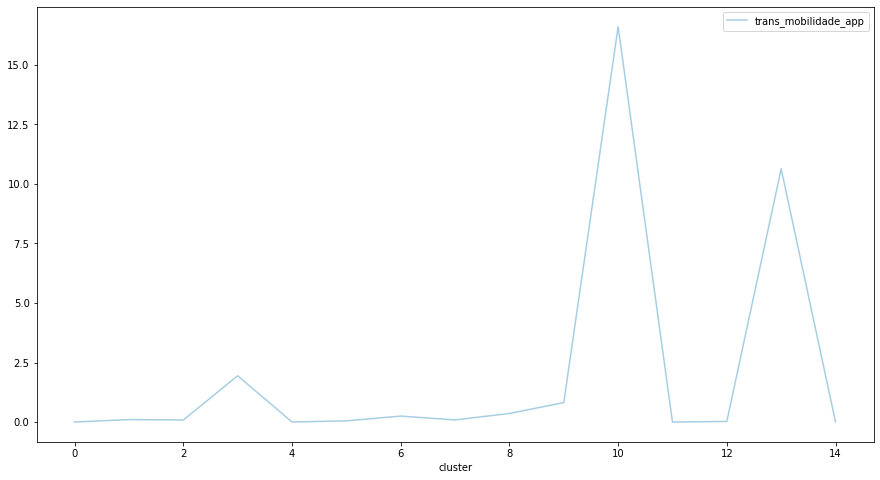

---------------MEDIAS POR CLUSTER GRÁFICO ------------
pc_acessos_lojawill


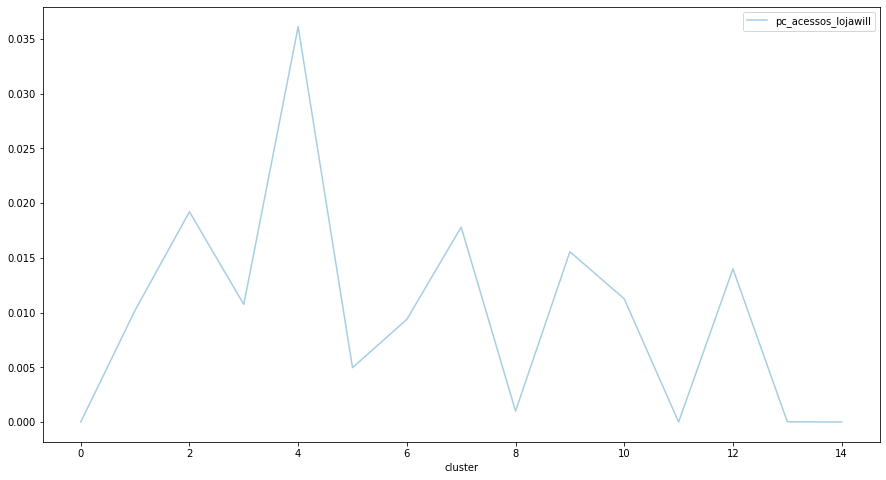

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_pagamentos_conta


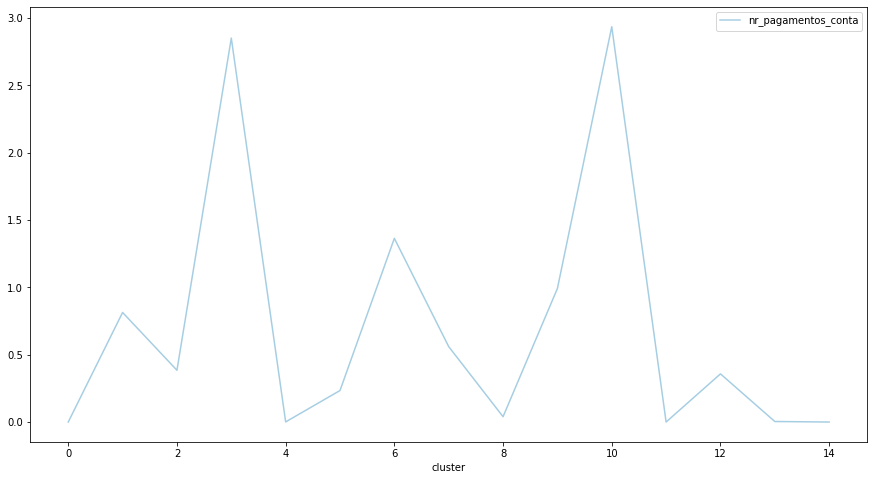

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_streaming


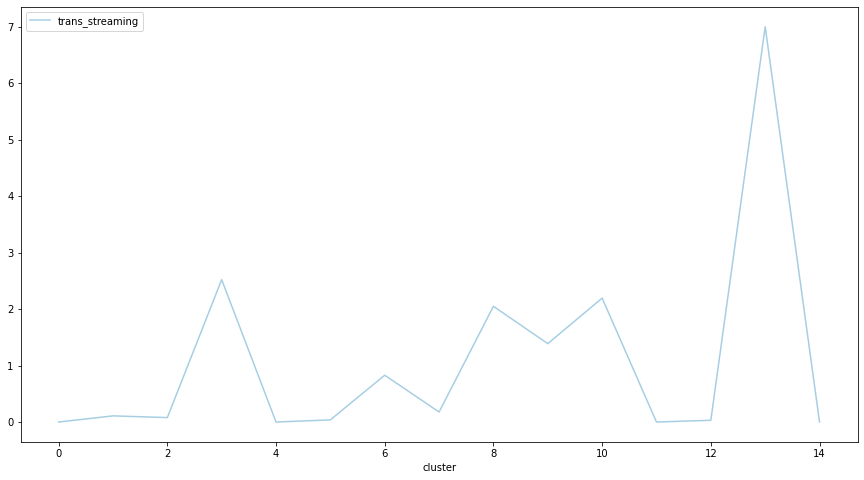

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_antecipacao_fatura


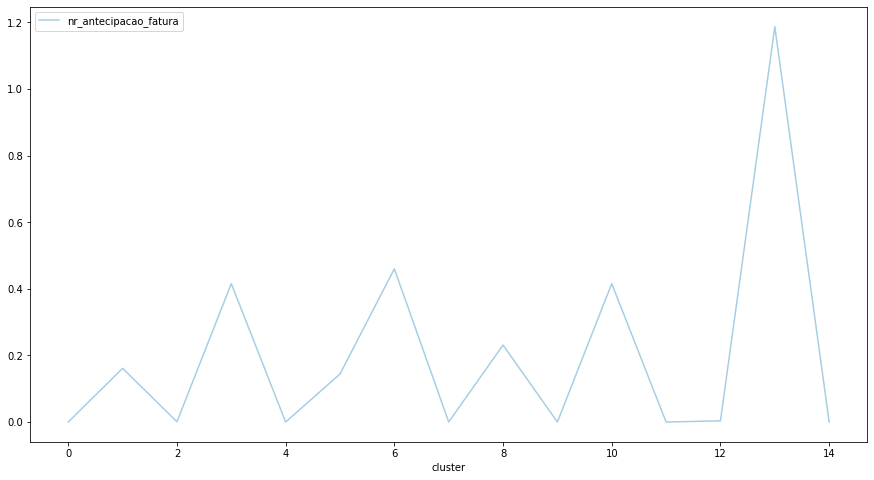

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_delivery


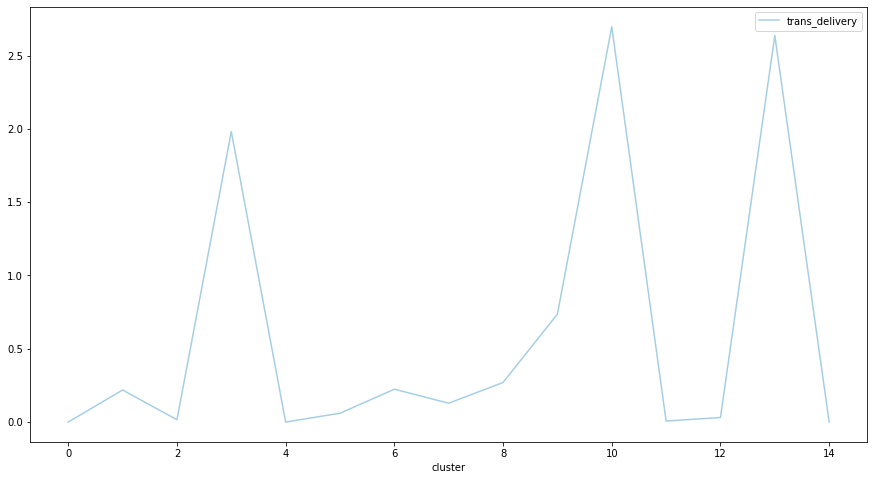

---------------MEDIAS POR CLUSTER GRÁFICO ------------
flag_bolso


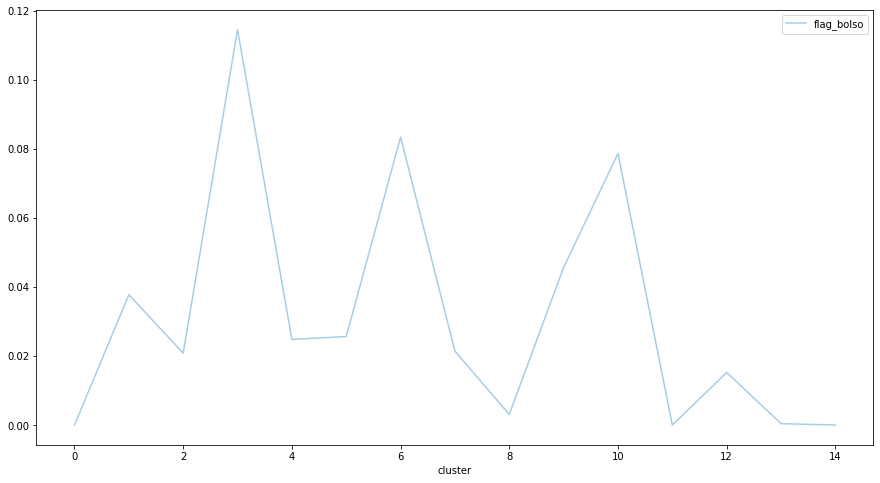

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_games


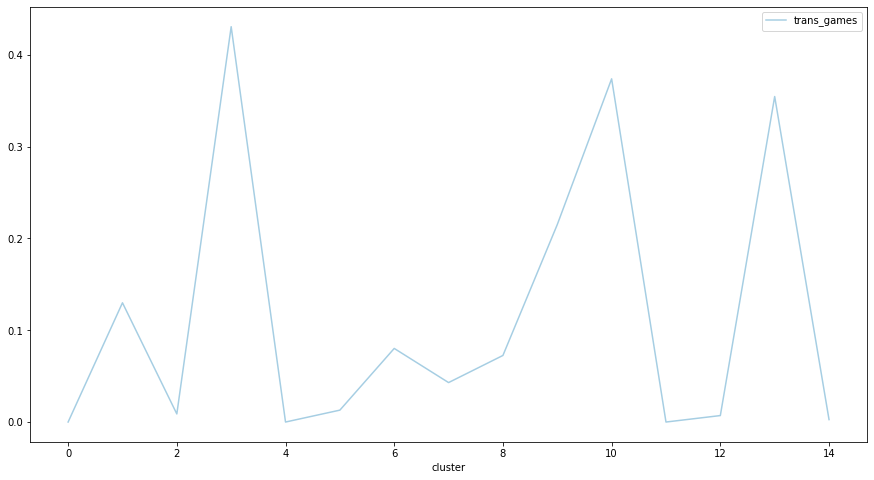

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_recarga_geral


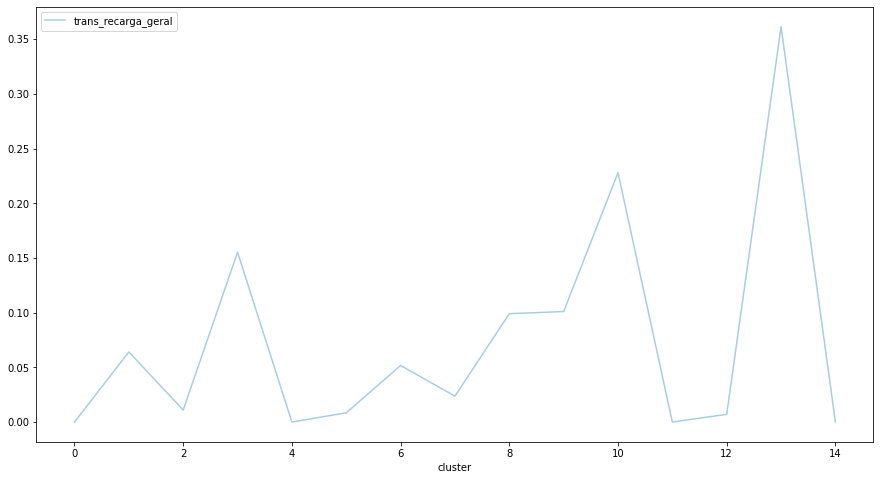

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_pagamentos_conta_credito


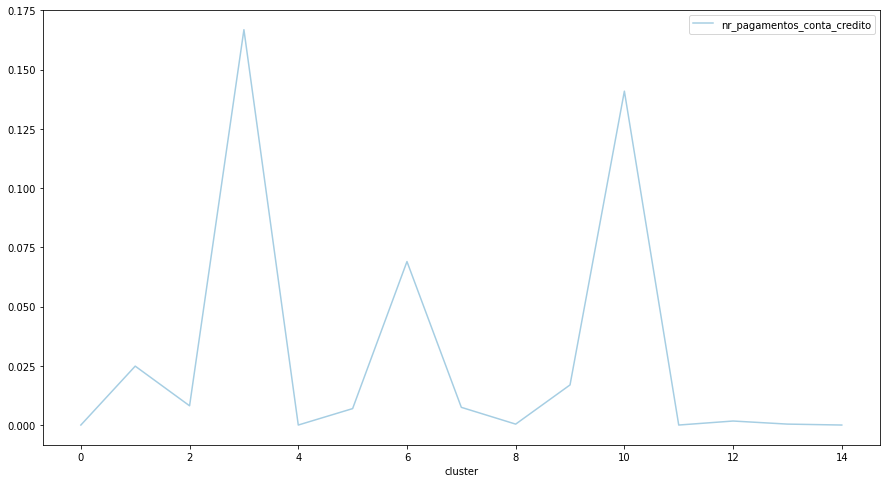

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_rede_social


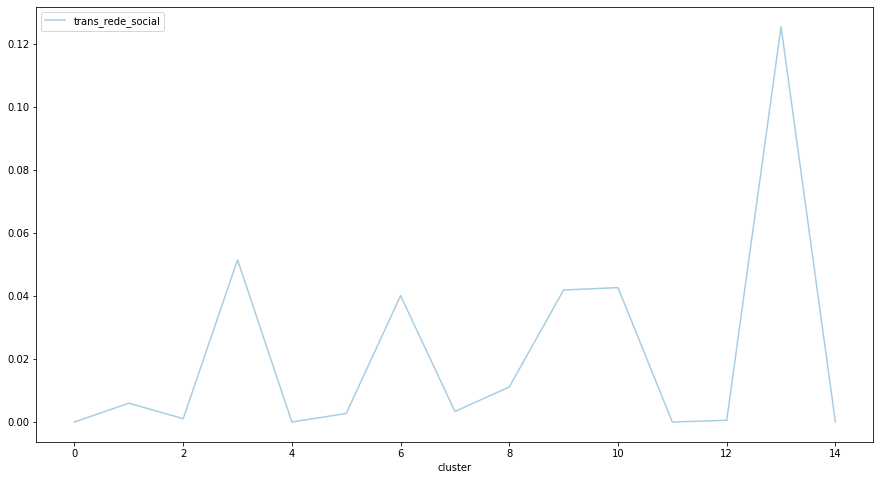

---------------MEDIAS POR CLUSTER GRÁFICO ------------
nr_recarga_credito


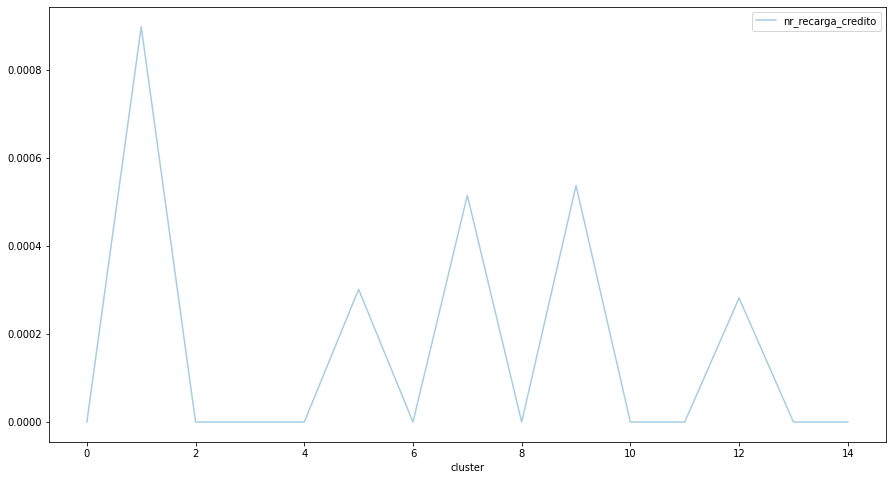

---------------MEDIAS POR CLUSTER GRÁFICO ------------
trans_cripto


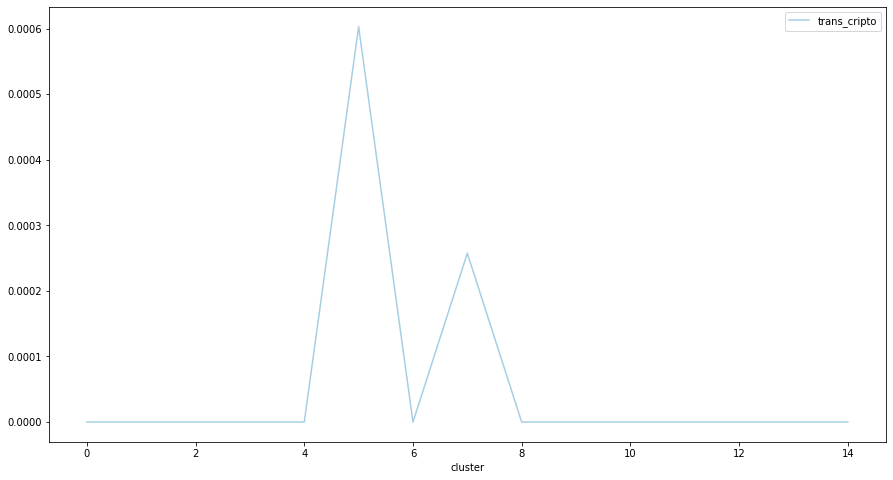

In [42]:
for i in features_importantes:
    print("---------------MEDIAS POR CLUSTER GRÁFICO ------------")
    print(i)
    plt.figure(figsize=(15,8))
    sns.lineplot(data = df[[i, 'cluster']].groupby('cluster').mean(), palette = 'Paired')
    plt.show()

In [106]:
pd.crosstab(df['cluster_regra'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster_regra,,,,,,,,,,,,,,,
AAAAA,0.401571,0.088434,0.082601,0.000997,0.033093,0.096905,0.006683,0.073279,0.070319,0.000733,0.000000,0.017440,0.104027,0.012897,0.011021
AAAAB,0.000000,0.009290,0.000000,0.003318,0.000000,0.000000,0.861314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126078,0.000000
AAAAC,0.000000,0.001681,0.000000,0.501401,0.000000,0.000000,0.377591,0.000000,0.000000,0.000000,0.115406,0.000000,0.000000,0.003922,0.000000
AAABA,0.000000,0.048780,0.043902,0.000000,0.000000,0.009756,0.024390,0.043902,0.214634,0.370732,0.009756,0.000000,0.000000,0.234146,0.000000
AAABB,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.680000,0.000000
AAABC,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.133333,0.000000
AAACA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.724138,0.000000,0.000000,0.241379,0.000000
AAACB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
AAACC,0.000000,0.000000,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000


In [60]:
df.groupby('cluster').agg(
    {
        'ds_risk_type': lambda x: x.value_counts().index[0],
        'gender': lambda x: x.value_counts().index[0],
        'ds_region': lambda x: x.value_counts().index[0],
        'nm_current_os': lambda x: x.value_counts().index[0],
        'ds_cluster_sociodemographic': lambda x: x.value_counts().index[0],
        'ds_occupation': lambda x: x.value_counts().index[0],
        'nr_declared_income':'median',
        'tempo_relacionamento': 'median',
        'flag_autonomo': lambda x: x.astype("string").value_counts().index[0],
        
    }
).reset_index()

,cluster,ds_risk_type,gender,ds_region,nm_current_os,ds_cluster_sociodemographic,ds_occupation,nr_declared_income,tempo_relacionamento,flag_autonomo
0,0,3. Medio Risco,FEMALE,Nordeste,android,"18 - Homem, 25 a 40 anos, Sudeste e Sul",AUTÔNOMO,0.01,1379.5,0
1,1,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",Autônomo(a),2000.00,419.0,0
2,2,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",Autônomo(a),2500.00,125.0,0
3,3,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",Autônomo(a),2000.00,373.0,0
4,4,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",Autônomo(a),2500.00,103.0,0
5,5,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",AUTÔNOMO,1500.00,677.0,0
6,6,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",Autônomo(a),2000.00,427.0,0
7,7,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",Autônomo(a),2500.00,173.0,0
8,8,3. Medio Risco,FEMALE,Nordeste,android,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",AUTÔNOMO,0.01,1163.0,0
9,9,4. Baixo Risco,FEMALE,Nordeste,android,"15 - Mulher, 25 a 40 anos, Nordeste",Autônomo(a),2500.00,196.0,0


In [59]:
pd.crosstab(df['ds_region'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
ds_region,,,,,,,,,,,,,,,
Centro-Oeste,0.250851,0.061436,0.057567,0.041937,0.023058,0.058496,0.056639,0.084494,0.051996,0.090994,0.079078,0.013618,0.066852,0.054937,0.008047
Nordeste,0.266490,0.077537,0.053980,0.056179,0.021404,0.074755,0.073634,0.072243,0.056134,0.059903,0.047788,0.009692,0.074038,0.049089,0.007135
Norte,0.233426,0.078082,0.069897,0.063349,0.026027,0.074153,0.084466,0.074971,0.044361,0.068587,0.051236,0.013423,0.069569,0.039450,0.009003
Sudeste,0.311804,0.051106,0.054497,0.035524,0.022848,0.054739,0.040610,0.081786,0.049572,0.089537,0.062167,0.013079,0.068626,0.057000,0.007105
Sul,0.309032,0.038085,0.056583,0.028292,0.022125,0.051505,0.033007,0.093217,0.048241,0.098658,0.073268,0.017048,0.069641,0.053319,0.007980


In [57]:
pd.crosstab(df['ds_cluster_sociodemographic'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
ds_cluster_sociodemographic,,,,,,,,,,,,,,,
"0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste",0.208679,0.097639,0.061264,0.042757,0.021698,0.091895,0.077218,0.079132,0.090619,0.056796,0.023612,0.007020,0.095086,0.043395,0.003191
"1 - Mulher, Solteira, Até 24 anos, cidade Média do Sudeste ou Sul",0.262958,0.039191,0.060051,0.050569,0.018331,0.041087,0.044880,0.079014,0.035398,0.122630,0.099874,0.015171,0.063211,0.061315,0.006321
"10 - Mulher, Solteira, Até 24 anos, cidade Pequena do Nordeste",0.216548,0.083387,0.043956,0.091791,0.017453,0.060763,0.124111,0.069813,0.037492,0.095023,0.047835,0.010989,0.047188,0.046542,0.007111
"11 - Homem, Solteiro, Até 24 anos, cidade Pequena do Nordeste",0.227658,0.069798,0.055447,0.103718,0.024788,0.054795,0.109589,0.060665,0.047619,0.068493,0.054795,0.006523,0.049576,0.058056,0.008480
"12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental cursando ou completo",0.200500,0.074329,0.062461,0.041224,0.028107,0.104310,0.081199,0.092442,0.054966,0.056839,0.038726,0.012492,0.110556,0.034354,0.007495
"13 - Homem, Solteiro, 35 anos ou mais, cidade Média do Norte ou Centro-Oeste",0.228528,0.079755,0.062883,0.055215,0.039877,0.069018,0.059816,0.075153,0.044479,0.070552,0.075153,0.010736,0.087423,0.033742,0.007669
"14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste",0.212141,0.093291,0.065176,0.044089,0.019808,0.092652,0.073482,0.089457,0.075399,0.058147,0.032588,0.013419,0.092652,0.030671,0.007029
"15 - Mulher, 25 a 40 anos, Nordeste",0.185363,0.091403,0.067434,0.056248,0.029083,0.078939,0.081815,0.096836,0.036433,0.085011,0.055928,0.014701,0.084692,0.026846,0.009268
"16 - Homem, 25 a 40 anos, Nordeste",0.341349,0.072812,0.036072,0.056112,0.020040,0.065464,0.069472,0.062124,0.053440,0.050100,0.039412,0.008684,0.058116,0.060788,0.006012


In [64]:
pd.crosstab(df['ds_city_size'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
ds_city_size,,,,,,,,,,,,,,,
grande,0.339280,0.050463,0.052197,0.039230,0.020648,0.058887,0.040634,0.063347,0.046085,0.070284,0.072927,0.011480,0.064503,0.063594,0.006442
medio,0.283697,0.062032,0.057789,0.046910,0.022066,0.059949,0.053622,0.075303,0.048453,0.078698,0.066662,0.012885,0.066276,0.056554,0.009104
pequeno,0.237255,0.077213,0.058241,0.053949,0.023786,0.073282,0.077414,0.085877,0.056917,0.074285,0.044683,0.011592,0.076571,0.041715,0.007220


In [65]:
pd.crosstab(df['nm_current_os'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
nm_current_os,,,,,,,,,,,,,,,
android,0.289365,0.071498,0.052589,0.047171,0.022666,0.070604,0.062708,0.079011,0.050161,0.068202,0.052205,0.010707,0.072469,0.043517,0.007129
ios,0.218664,0.049880,0.071323,0.053562,0.022271,0.050985,0.061016,0.072888,0.059083,0.097000,0.075281,0.016197,0.065618,0.077305,0.008927


In [67]:
pd.crosstab(df['flag_autonomo'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
flag_autonomo,,,,,,,,,,,,,,,
0,0.269628,0.062513,0.060040,0.043316,0.023258,0.067488,0.059959,0.081254,0.053291,0.078673,0.057082,0.012718,0.072166,0.050764,0.007851
1,0.286696,0.079247,0.046846,0.063788,0.020612,0.063007,0.069254,0.067302,0.048641,0.062227,0.057620,0.009525,0.067536,0.051140,0.006558


In [66]:
pd.crosstab(df['ds_risk_type'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
ds_risk_type,,,,,,,,,,,,,,,
1. Sem Informacao,0.634783,0.029217,0.011478,0.013043,0.004348,0.055478,0.021217,0.010435,0.086087,0.006783,0.009565,0.003130,0.028000,0.084000,0.002435
2. Alto Risco,0.316798,0.062732,0.046585,0.058550,0.018355,0.062616,0.069122,0.072723,0.048559,0.061571,0.043099,0.009758,0.066334,0.055878,0.007319
3. Medio Risco,0.270619,0.063993,0.053589,0.052020,0.022493,0.065214,0.068527,0.072421,0.055333,0.075385,0.053705,0.010346,0.070212,0.057890,0.008253
4. Baixo Risco,0.144655,0.083040,0.078321,0.051744,0.030319,0.072517,0.066226,0.105874,0.040137,0.100721,0.081955,0.017085,0.087270,0.031621,0.008515


In [68]:
cbo_query = """

select * from customer_curated_zone.ca_dict_occupations 

"""

cbo = ac.df_athena('flavia-costa', cbo_query)

In [71]:
df = df.join(cbo.set_index('ds_occupation'), how = 'left', on = 'ds_occupation')


ValueError: columns overlap but no suffix specified: Index(['ds_occupation_processed', 'ds_occupation_reduced', 'ds_cbo_group'], dtype='object')

In [72]:
df.ds_cbo_group.value_counts()

TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉRCIO EM LOJAS E MERCADOS                                          10183
AUTÔNOMOS                                                                                                        9801
TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS                                                                        6492
PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS, HUMANAS E DAS ARTES                                               6148
MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES DE ORGANIZAÇÕES DE INTERESSE PÚBLICO E DE EMPRESAS, GERENTES     4221
OUTROS                                                                                                           3537
TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUTENÇÃO                                                              2076
TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA PESCA                                                               1871
TÉCNICOS DE NIVEL MÉDIO                                 

In [75]:
pd.crosstab(df['gender'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
gender,,,,,,,,,,,,,,,
FEMALE,0.255050,0.067660,0.058511,0.045924,0.023309,0.066708,0.062829,0.082955,0.050059,0.082955,0.057816,0.012734,0.075490,0.050644,0.007355
MALE,0.296842,0.065764,0.054428,0.051738,0.021701,0.065896,0.061750,0.071321,0.054561,0.064220,0.056501,0.010894,0.065543,0.051120,0.007719


In [76]:
pd.crosstab(df['gender'], df['cluster'], normalize='columns').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
gender,,,,,,,,,,,,,,,
FEMALE,0.508759,0.553593,0.564419,0.516886,0.564216,0.549593,0.550850,0.583677,0.525144,0.608918,0.552254,0.584874,0.581291,0.544239,0.534574
MALE,0.491241,0.446407,0.435581,0.483114,0.435784,0.450407,0.449150,0.416323,0.474856,0.391082,0.447746,0.415126,0.418709,0.455761,0.465426


In [73]:
pd.crosstab(df['ds_cbo_group'], df['cluster'], normalize='index').style.apply(highlight_max)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
ds_cbo_group,,,,,,,,,,,,,,,
APOSENTADOS,0.235019,0.056809,0.083268,0.031907,0.029572,0.089494,0.040467,0.100389,0.063813,0.064591,0.027237,0.010117,0.126848,0.029572,0.010895
AUTÔNOMOS,0.300990,0.070197,0.055709,0.042955,0.020304,0.073462,0.065401,0.075196,0.054382,0.059688,0.040710,0.011121,0.075094,0.047954,0.006836
DONAS DE CASA,0.046832,0.107438,0.074380,0.063361,0.049587,0.071625,0.088154,0.140496,0.013774,0.123967,0.063361,0.035813,0.115702,0.000000,0.005510
ESTUDANTES,0.288401,0.050157,0.050157,0.052038,0.020690,0.052665,0.065831,0.062069,0.055172,0.086520,0.059561,0.007524,0.043260,0.100313,0.005643
"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEIROS MILITARES",0.323171,0.036585,0.057927,0.036585,0.015244,0.073171,0.042683,0.057927,0.045732,0.094512,0.067073,0.018293,0.073171,0.051829,0.006098
"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES DE ORGANIZAÇÕES DE INTERESSE PÚBLICO E DE EMPRESAS, GERENTES",0.286425,0.065387,0.063255,0.046434,0.025823,0.057095,0.053779,0.072732,0.058517,0.074153,0.054016,0.012556,0.068230,0.051883,0.009713
OUTROS,0.345773,0.064461,0.037602,0.045236,0.015550,0.063048,0.063048,0.057393,0.071812,0.045519,0.044953,0.009047,0.060786,0.069833,0.005937
"PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS, HUMANAS E DAS ARTES",0.271633,0.061158,0.054489,0.044730,0.024236,0.058718,0.046682,0.077749,0.051236,0.084255,0.074333,0.015452,0.068478,0.058068,0.008783
"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA PESCA",0.195617,0.084981,0.057723,0.060396,0.026724,0.077499,0.087654,0.100481,0.047034,0.079637,0.045965,0.012827,0.080171,0.032068,0.011224


### Nome do cluster e marcação por regras

In [78]:
df['ds_perfil_conexão'] = np.where(df.cluster == 6, "Conectado em ascensão",
                          np.where(df.cluster == 10, "Conectado Fiel",         
                          np.where(df.cluster == 13, "Conectado Organizado",         
                          np.where(df.cluster == 3, "Hiperconectado", "Outros"))))

df['ds_perfil_conexão'].value_counts()

Outros                   39051
Conectado em ascensão     3117
Conectado Fiel            2861
Conectado Organizado      2543
Hiperconectado            2428
Name: ds_perfil_conexão, dtype: int64

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

In [84]:
# Conectado em ascenção

df['target'] = np.where(df.ds_perfil_conexão == "Conectado em ascensão", 1, 0)

x_train, x_test, y_train, y_test = train_test_split(df[features_cluster]
                                                    , df['target']
                                                    , random_state=42, test_size=0.20)

clf = RandomForestClassifier(n_estimators=200)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, scoring='f1_macro' , cv = StratifiedKFold(n_splits=3))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

y_predicted = clf.predict(x_test)

print(classification_report(y_test, y_predicted))

0.96 F1 with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9404
           1       0.95      0.89      0.92       596

    accuracy                           0.99     10000
   macro avg       0.97      0.94      0.96     10000
weighted avg       0.99      0.99      0.99     10000



In [85]:
# Conectado em Fiel

df['target'] = np.where(df.ds_perfil_conexão == "Conectado Fiel", 1, 0)

x_train, x_test, y_train, y_test = train_test_split(df[features_cluster]
                                                    , df['target']
                                                    , random_state=42, test_size=0.20)

clf = RandomForestClassifier(n_estimators=200)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, scoring='f1_macro' , cv = StratifiedKFold(n_splits=3))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

y_predicted = clf.predict(x_test)

print(classification_report(y_test, y_predicted))

0.97 F1 with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9408
           1       0.94      0.96      0.95       592

    accuracy                           0.99     10000
   macro avg       0.97      0.98      0.97     10000
weighted avg       0.99      0.99      0.99     10000



In [86]:
# Conectado Organizado

df['target'] = np.where(df.ds_perfil_conexão == "Conectado Organizado", 1, 0)

x_train, x_test, y_train, y_test = train_test_split(df[features_cluster]
                                                    , df['target']
                                                    , random_state=42, test_size=0.20)

clf = RandomForestClassifier(n_estimators=200)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, scoring='f1_macro' , cv = StratifiedKFold(n_splits=3))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

y_predicted = clf.predict(x_test)

print(classification_report(y_test, y_predicted))

0.97 F1 with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9495
           1       0.96      0.94      0.95       505

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.99      0.99      0.99     10000



In [87]:
# Hiperconectado

df['target'] = np.where(df.ds_perfil_conexão == "Hiperconectado", 1, 0)

x_train, x_test, y_train, y_test = train_test_split(df[features_cluster]
                                                    , df['target']
                                                    , random_state=42, test_size=0.20)

clf = RandomForestClassifier(n_estimators=200)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, scoring='f1_macro' , cv = StratifiedKFold(n_splits=3))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

y_predicted = clf.predict(x_test)

print(classification_report(y_test, y_predicted))

0.97 F1 with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9520
           1       0.96      0.91      0.94       480

    accuracy                           0.99     10000
   macro avg       0.98      0.96      0.97     10000
weighted avg       0.99      0.99      0.99     10000



### Teste com regras

In [107]:
# Conectado em ascensão - cl6
df['target'] = np.where(df.ds_perfil_conexão == "Conectado em ascensão", 1, 0)
df['target_regras'] = np.where(np.isin(df.cluster_regra, ["AAAAB",	"AAABC", "AAACB","AABAB","AABBB","BAAAB","BAABB","BAABC","BABAB","BABBB"]), 1, 0)

print(classification_report(df['target'], df['target_regras']))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     46883
           1       0.77      0.57      0.66      3117

    accuracy                           0.96     50000
   macro avg       0.87      0.78      0.82     50000
weighted avg       0.96      0.96      0.96     50000



In [108]:
# Conectado Fiel - cl10
df['target'] = np.where(df.ds_perfil_conexão == "Conectado Fiel", 1, 0)
df['target_regras'] = np.where(np.isin(df.cluster_regra, ["AAACA","AABBA","AABCA","AABCB","ABBAB","ABBBA","ABBCA","ABBCB","ABBCC","BAACC","BABBA","BABBB","BABCA","BABCC","BBACA","BBACB","BBBAB","BBBBA","BBBCA","BBBCB"]), 1, 0)

print(classification_report(df['target'], df['target_regras']))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     47139
           1       0.79      0.28      0.42      2861

    accuracy                           0.95     50000
   macro avg       0.87      0.64      0.70     50000
weighted avg       0.95      0.95      0.94     50000



In [109]:
#  Conectado Organizado - cl13
df['target'] = np.where(df.ds_perfil_conexão == "Conectado Organizado", 1, 0)
df['target_regras'] = np.where(np.isin(df.cluster_regra, ["AAABB","ABAAA","ABAAB","ABABA","ABABB","ABACA","ABACB","ABACC"]), 1, 0)

print(classification_report(df['target'], df['target_regras']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     47457
           1       0.75      0.67      0.71      2543

    accuracy                           0.97     50000
   macro avg       0.87      0.83      0.85     50000
weighted avg       0.97      0.97      0.97     50000



In [116]:
#  Hiperconectado - cl3
df['target'] = np.where(df.ds_perfil_conexão == "Hiperconectado", 1, 0)
df['target_regras'] = np.where(np.isin(df.cluster_regra, ["AAAAC",	"AAACC","AABAC","AABCC","ABBAC","AABBC", "ABBBC","BAAAC","BABAC","BABBC","BBAAC","BBABC","BBACC","BBBAC","BBBBC"]), 1, 0)

print(classification_report(df['target'], df['target_regras']))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     47572
           1       0.58      0.74      0.65      2428

    accuracy                           0.96     50000
   macro avg       0.78      0.86      0.81     50000
weighted avg       0.97      0.96      0.96     50000



###  Teste com regras de variaveis e percentis

In [124]:
# Conectado em ascensão - cl6
df['target'] = np.where(df.ds_perfil_conexão == "Conectado em ascensão", 1, 0)


#Alto acesso / Paga com conta / top 3 pix / antecipação / bolso

df['target_regras'] = np.where((df.nr_acessos > df.nr_acessos.quantile(0.50)) & (df.nr_trans_pix > df.nr_trans_pix.quantile(0.50)) & ((df.nr_pagamentos_conta > df.nr_pagamentos_conta.quantile(0.50))|
                                (df.nr_antecipacao_fatura > df.nr_antecipacao_fatura.quantile(0.50)) | (df.flag_bolso > 0)), 1, 0)

print(df['target_regras'].value_counts())

print(classification_report(df['target'], df['target_regras']))

0    45951
1     4049
Name: target_regras, dtype: int64
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     46883
           1       0.25      0.33      0.29      3117

    accuracy                           0.90     50000
   macro avg       0.60      0.63      0.62     50000
weighted avg       0.91      0.90      0.90     50000



In [126]:
#  Hiperconectado - cl3
df['target'] = np.where(df.ds_perfil_conexão == "Hiperconectado", 1, 0)

df['target_regras'] = np.where((df.nr_acessos > df.nr_acessos.quantile(0.50)) & (df.nr_trans_pix > df.nr_trans_pix.quantile(0.50)) & 
                               (df.nr_purchases_contactless > df.nr_purchases_contactless.quantile(0.50)) &
                               ((df.nr_pagamentos_conta > df.nr_pagamentos_conta.quantile(0.50))|
                                (df.nr_antecipacao_fatura > df.nr_antecipacao_fatura.quantile(0.50)) | (df.flag_bolso > 0)), 1, 0)
print(df['target_regras'].value_counts())
print(classification_report(df['target'], df['target_regras']))

0    47113
1     2887
Name: target_regras, dtype: int64
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     47572
           1       0.29      0.35      0.32      2428

    accuracy                           0.93     50000
   macro avg       0.63      0.65      0.64     50000
weighted avg       0.93      0.93      0.93     50000



### Amostra para análise Polis

In [127]:
'''
Conectado em ascensão     3117
Conectado Fiel            2861
Conectado Organizado      2543
Hiperconectado            2428
'''

segmentos = ['Conectado em ascensão', 'Conectado Fiel', 'Conectado Organizado', 'Hiperconectado']

for i in segmentos:
    df.query(f'ds_perfil_conexão == "{i}"')[['cpf']].to_csv(f'{i}.csv', index=False)

